# Surface Equilibrium Calculations

Here, we will use a relatively simple concept--surface-gas equilibrium--to demonstrate some of Cantera's capabilities for heterogeneous catalysis applications.

Consider adsorption-desorption reactions between a gas phase and an ideal surface lattice.

<img src="../images/SurfaceReactions.png" alt="Cartoon of an ideal surface lattice (left side), and of the H2 adsorption reaction (right side)." style="width: 750px;"/>

Note that the exact geometry of the lattice is irrelevant; the only assumption is a user-supplied density of surface sites, $\Gamma_\circ $, with units ${\rm \left[\frac{mol}{m^2}\right]}$.

## Surface equilbrium

There are two possible ways to express the equilibrium condition, for a given temperature $T$ and pressure $p$: 
1. Thermodynamically via the Gibbs free energy of the reaction, $\Delta G_{\rm rxn}$:
<div class="alert-danger">
$$\Delta G_{\rm rxn} = \sum_k \nu_k \mu_k = \sum_k \nu_k\left(\mu^\circ_k + RT \ln a_k\right) = 0, $$
</div>
where $\nu_k$ is the net stoichiometric coefficient for species $k$, $\mu_k$ the chemical potential, $\mu^\circ_k$ the standard state chemical potential, and $a_k$ the species activity, which depends on the state.
2. Kinetically via the reaction rate of progress, $\dot{q}_{\rm rxn}$:
<div class="alert-danger">
$$\dot{q}_{\rm rxn} = k_{\rm fwd,\,rxn}\prod_k C_{{\rm ac},k}^{\nu^\prime_{k,\,{\rm rxn}}} - k_{\rm rev,\,rxn}\prod_k C_{{\rm ac},k}^{\nu^{\prime\prime}_{k,\,{\rm rxn}}},$$
</div>
where $k_{\rm fwd,\,rxn}$ and $k_{\rm rev,\,rxn}$ are the forward and reverse rate coefficients, $C_{\rm ac,k}$ the activity concentration of species $k$ (equal to $\gamma_kC_k$, the activity coefficient times the molar concentration, with units of $\left[ \frac{mol}{m^2}\right]$ for a surface phase and $\left[ \frac{mol}{m^3}\right]$ for a bulk (e.g. gas) phase, and $\nu^\prime_{k,\,{\rm rxn}}$ and $\nu^{\prime\prime}_{k,\,{\rm rxn}}$ the forward and reverse stoichiometric coefficients for species $k$ in the reaction (note $\nu_{k,\,{\rm rxn}} = \nu^{\prime\prime}_{k,\,{\rm rxn}} - \nu^{\prime}_{k,\,{\rm rxn}}$).

In Cantera, whenever any reaction is written as reversible, the reverse rate coefficient $k_{\rm rev,\,rxn}$ is calculated according to the thermodynamics, assuming a _single_ equilibrium state that satisfies the two equations above.  In other words, the two approaches should give equivalent results. The activities and activity concentrations are linked via:
$$ a_k = \frac{C_{{\rm ac},k}}{C^\circ_k},$$
where $C^\circ_k$ is a reference concentration (the reference state being that at which $\mu^\circ_k$ is known/evaluated).

## Surface equilibrium: by hand.

Let's consider the "simple example" shown above, for hydrogen adsorption on a Pt surface:
$${\rm H_{2(g)} + 2\,Pt_{(s)} \leftrightharpoons 2\,H_{(s)}}$$
We will evaluate the equilibrium calculation kinetically, solving for the state where $\dot{q}_{\rm rxn} = 0$:
<div class="alert-danger">
$$\dot{q}_{\rm rxn} = k_{\rm fwd}C_{H_{\rm 2(g)}}C^2_{\rm Pt(s)} - k_{\rm rev}C^2_{\rm H(s)}.$$
</div>
Setting $\dot{q}_{\rm rxn} = 0$ leads to:

$$k_{\rm fwd}C_{H_{\rm 2(g)}}C^2_{\rm Pt(s)} = k_{\rm rev}C^2_{\rm H(s)}.$$
and:
$$\frac{C^2_{\rm Pt(s)}}{C^2_{\rm H(s)}} = \frac{k_{\rm rev}}{k_{\rm fwd}C_{H_{\rm 2(g)}}}$$
where we can rewrite the ratio $\frac{k_{\rm rev}}{k_{\rm fwd}}$ in terms of the eqilibrium constant, $\frac{k_{\rm rev}}{k_{\rm fwd}} = \frac{1}{K_c}$.
The surface concentrations can be written as $C_k = \Gamma_\circ\theta_k$, where $\theta_k$ is the 'surface coverage' - the percentage of surface sites occupied by species $k$.

$$\frac{C^2_{\rm Pt(s)}}{C^2_{\rm H(s)}} = \frac{\Gamma_\circ^2\theta^2_{\rm Pt(s)}}{\Gamma_\circ^2\theta^2_{\rm H(s)}}= \frac{\theta^2_{\rm Pt(s)}}{\theta^2_{\rm H(s)}} = \frac{1}{K_cC_{H_{\rm 2(g)}}}$$

Lastly, we can take advantage of the fact that there are only two surface species, and so therefore $\theta_{\rm Pt(s)} = 1 - \theta_{\rm H(s)}$:
$$\frac{\left(1 - \theta_{\rm H(s)}\right)^2}{\theta^2_{\rm H(s)}} = \frac{1}{K_cC_{H_{\rm 2(g)}}}$$

After some algebra, we can solve for $\theta_{\rm H(s),\,equil}$:

<div class="alert-danger">
    $$\theta_{\rm H(s),\,equil} = \frac{1}{1 + \sqrt{\frac{1}{K_cC_{\rm H_{\rm 2(g)}}}}}$$
</div>

### User Inputs:

In [2]:
T = 300.                      # Temperature in K
P = 101325.                   # Pressure in Pa
X_H2_gas = 0.03               # H2(g) mole fraction
R = 8314.5                    # J/kmol-K

# Equilibrium constant evaluated from rate constants taken from Deutschman et al., 
#   26th Symp. (Intl.) on Combustion, 1996 pp. 1747-1754
K_eq = 0.1134077 # m^3/kmol

### Calculate terms and find equilibrium coverage by hand:

In [3]:
# Hydrogen concentration:
C_H2 = X_H2_gas*P/R/T

hand_coverage = 1./(1. + (1/K_eq/C_H2)**0.5)
print('Equilibrium H(s) coverage: ')
print('     by hand:      ', hand_coverage)

Equilibrium H(s) coverage: 
     by hand:       0.011619453378169624


# Perform the same calculation in Cantera

### Import packages

In [4]:
import cantera as ct
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import cycler
ct.__version__

'2.5.1'

### 1. Create Cantera phase objects:

In [5]:
mech_file = '../inputs/ptcombust_simple.yaml'

gas = ct.Solution(mech_file, 'gas')
surf = ct.Interface(mech_file, 'Pt_surf', [gas])

### 2. Set conditions

In [6]:
# Input string for molefractions.  Assume balance is inert Ar.
X_gas = f'H2:{X_H2_gas}, Ar:{1.-X_H2_gas}'

# Set Canera object states:
gas.TPX = T, P, X_gas
surf.TP = T, P

### Check similarity to hand calcs by printing out kinetic rate constants:

The H2 adsorption reaction is the first one listed, which will be reaction '0'. The mechanism writes reactions as irreversible pairs.  The reverse reaction is written as the second listed reaction, with index '1'.

In [11]:
k_fwd_ct = surf.forward_rate_constants[0]
k_rev_ct = surf.forward_rate_constants[1]
K_eq_ct = k_fwd_ct/k_rev_ct

# Reac out H2(g) concentration from Cantera:
C_H2_ct = gas['H2'].concentrations[0]

# Let's check to be sure our terms are the same:
print('Equilibrium Constant Kc: ', K_eq, round(K_eq_ct,7))
print('H2(g) concentration; ', round(C_H2,6), round(C_H2_ct,6))

Equilibrium Constant Kc:  0.1134077 0.1134077
H2(g) concentration;  0.001219 0.001219


### 3. Run Calculation

We will find the equilbrium coverage by integrating the surface coverages, assuming a fixed bulk (i.e. gas) phase, which is achieved using Cantera's "advance_coverages" method.

We assume 100 seconds is more than enough to reach equilibrium.

In [12]:
# Print the species production rates before equilibration:
print('Net species production rates: all phases')
print(surf.net_production_rates)
# This contains species for all relevant phases -- gas and surf.  
#  Let's look at just the surface species:
print('\n Net species production rates: surface only')
print(surf.get_net_production_rates(surf))

surf.advance_coverages(100)

# Print the species production rates after equilibration:
print('\n Net species production rates: after equilibration')
print(surf.get_net_production_rates(surf))


#Let's print the state:
surf()

Net species production rates: all phases
[ 2.49293099e-07 -2.49293099e-07  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.24646550e-07
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00]

 Net species production rates: surface only
[ 2.49293099e-07 -2.49293099e-07  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00]

 Net species production rates: af

In [13]:
# From the input file, H(S) is the 2nd species listed, which has index 1 in Python:

cantera_coverage = surf.coverages[1]
print('Equilibrium H(s) coverage: ')
print('     from Cantera: ', cantera_coverage)
print('     by hand:      ', hand_coverage)
print('Difference = ', round(cantera_coverage - hand_coverage,19))


Equilibrium H(s) coverage: 
     from Cantera:  0.011619479280108393
     by hand:       0.011619453378169624
Difference =  2.59019387692e-08


## We get the exact same result - great! 

In [14]:
# Note we can find the H(S) species index, without going to the input file:
print(surf.species_index('H(S)'))

# Or access it directly in the call to the Cantera object:
print(surf['H(S)'].coverages)

1
[0.01161948]


## But that felt like a good bit more typing, versus a relatively straightforward hand calculation (once we work out the theory).  Why use Cantera?

For more complex chemistry, the hand calculation becomes more difficult, but is exactly the same in Cantera.  Have a look at the input file chemistry.  If we throw some methane and oxygen in to the gas phase, many more species and reactions become relevant.

In [15]:
# Note that Cantera automatically normalizes the composition so that mole fractions sum to one
gas.X = 'CH4:0.49, O2:0.21, N2:0.79' 
surf.advance_coverages(100)
surf()


  Pt_surf:

       temperature   300 K
          pressure   1.0132e+05 Pa
           density   5.7579e-06 kg/m^3
  mean mol. weight   212.76 kg/kmol
   phase of matter   unspecified

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy       -6.1133e+05       -1.3006e+08  J
   internal energy       -6.1133e+05       -1.3006e+08  J
           entropy            83.768             17822  J/K
    Gibbs function       -6.3646e+05       -1.3541e+08  J
 heat capacity c_p            61.978             13186  J/K
 heat capacity c_v            61.978             13186  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
             PT(S)        3.9575e-07         4.316e-07           -14.656
             OH(S)        6.2427e-07        6.2624e-07           -99.506
             CO(S)            0.1463           0.13952     

### Okay, so the surface is mostly covered by oxygen.  Let's see how this changes with temperature:

In [16]:
nT = 50  # Number of temperatures to evaluate
Temps = np.linspace(300, 1500, nT)
thetas = np.zeros((nT, surf.n_species))

for j, T_j in enumerate(Temps):
    gas.TP = T_j, P
    surf.TP = T_j, P
    surf.advance_coverages(100)
    thetas[j,:] = surf.coverages

## Plot $\theta_k$ vs. T


In [17]:
def plot_coverages(temperature, coverages):
    """
    temperature: a numpy array of temperature
    coverages: a numpy array of coverage of species
    """
    fs = 15
    n = 12
    colors = np.linspace(0, 1, n)
    color = plt.cm.plasma(colors)
    mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

    # Create 3 subplots:
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(8,3))

    # Plot all species:
    ax1.plot(temperature, coverages)
    ax1.set_yticks([0, .25, .5, .75, 1.])
    ax1.title.set_text('All species')

    # Omit O(s) and Pt(s):
    color = plt.cm.plasma(colors[1:-1])
    mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
    ax2.plot(temperature, coverages[:, 1:-1])
    ax2.title.set_text('No PT(S) and O(S)')

    ax2.set_ylim(0, 0.4)
    ax2.set_yticks([0, .1, .2, .3, .4])

    # Also omit CH3(S) and CO(S):
    indices = np.hstack((np.arange(1,4),np.arange(5,9)))

    color = plt.cm.plasma(colors[indices])
    mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

    ax3.plot(temperature, coverages[:, indices])
    ax3.set_ylim(0, 0.004)
    ax3.set_yticks([0, .001, .002, .003, .004])
    ax3.title.set_text('No PT(S), O(S), or CO(S)')

    ax1.set_ylabel('Coverage', fontsize=fs)
    f.text(0.5, -0.05, 'Temperature (K)', fontsize=fs, ha='center')
    f.tight_layout()
    f.legend(surf.species_names, frameon=False, bbox_to_anchor=(1.12,.9))

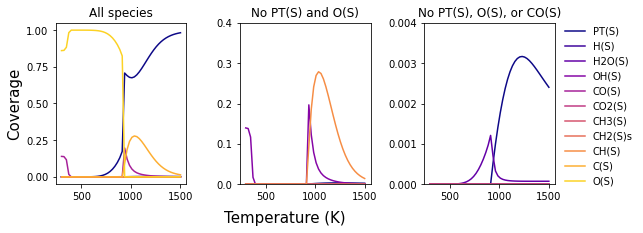

In [18]:
plot_coverages(Temps, thetas)

Lastly, note that there is nothing inherently "true" about these calculations.  Cantera takes a user-provided input file, and calculates the desired properties, rates, etc., _given those inputs_.  

The point of Cantera is to provide automated and generalized chemical kinetic routines.  This increases efficiency and repeatability of these calculations. The software is not, however, in the business of endorsing any particular mechanism. 

In particular, the mechanism used above write the reversible reactions as irreversible pairs, providing a rate constant for each direction.  There is no guarantee that these rate constant pairs are consistent with thermodynamics, which states that $\frac{k_{\rm fwd}}{k_{\rm rev}} = exp\left(-\frac{\Delta G^\circ_{\rm rxn}}{RT}\right)C^{\circ\,\sum \nu_k}$. _It is up to the user to verify the validity of their chosen mechanism_.

If we want to switch to a completely different mechanism, the routine is exactly the same:

In [19]:
mech_file = 'methane_pox_on_pt.yaml' # This is another mechanism from the Deutschmann group.

gas = ct.Solution(mech_file, 'gas')
surf = ct.Interface(mech_file, 'Pt_surf', [gas])

gas.TPX = T, P, X_gas
surf.TP = T, P

# Read the properties from the input file:
k_fwd_ct = surf.forward_rate_constants[0]
k_rev_ct = surf.forward_rate_constants[1]

C_H2_ct = gas['H2'].concentrations[0]

hand_coverage = 1./(1. + (k_rev_ct/k_fwd_ct/C_H2_ct)**0.5)

surf.advance_coverages(100)
cantera_coverage = surf['H(S)'].coverages[0]

print('Equilibrium H(s) coverage: ')
print('     from Cantera: ', cantera_coverage)
print('     by hand:      ', hand_coverage)
print('Difference = ', round(cantera_coverage - hand_coverage,19))


Equilibrium H(s) coverage: 
     from Cantera:  0.9988917661803131
     by hand:       0.3569548911481857
Difference =  0.6419368750321274


Here, we can see that the hand calculation is quite a bit off.  If we explore the kinetic mechanism in the input file, we see that the reaction rate has a coverage dependence, which makes the hand calculation considerably more challenging, but does not impact the Cantera-based approach.